In [16]:
import argparse
import sys, os

import json

In [2]:
import tensorflow as tf
import numpy as np

def reshape_outputs(img_shape=(32, 32)):
    def reshaping(inputs, targets):
        targets = tf.image.resize(targets, img_shape)
        targets = tf.math.ceil(targets)
        return inputs, targets

    return reshaping


def parse_function(img_shape=(128, 128, 1), test=False, clip=True):
    """

    :param img_shape:
    :param test:
    :param clip:
    :return:
    """
    def parsing(example_proto):
        keys_to_features = {'x': tf.io.FixedLenFeature(shape=img_shape, dtype=tf.float32),
                            'y': tf.io.FixedLenFeature(shape=img_shape, dtype=tf.int64)}
        parsed_features = tf.io.parse_single_example(example_proto, keys_to_features)
        parsed_features['y'] = tf.cast(parsed_features['y'], tf.float32)
        if clip:
            parsed_features['x'] = tf.clip_by_value(parsed_features['x'], -166.43, 169.96)
        if test:
            return parsed_features['x']
        else:
            return parsed_features['x'], parsed_features['y']

    return parsing

def get_shape_of_quadratic_image_tfrecord(raw_dataset):
    keys_to_features = {'x': tf.io.VarLenFeature(dtype=tf.float32),
                        'y': tf.io.VarLenFeature(dtype=tf.int64)}
    for i in raw_dataset.take(1):
        parsed_features = tf.io.parse_single_example(i, keys_to_features)
        return int(np.sqrt(parsed_features["x"].shape[0])), int(np.sqrt(parsed_features["x"].shape[0])), 1

dataset = tf.data.TFRecordDataset(["../DATA1/val.tfrecord"])
tfrecord_shape = get_shape_of_quadratic_image_tfrecord(dataset)
dataset_reshaped = dataset.map(parse_function(img_shape=tfrecord_shape, test=False))
for i,j in dataset_reshaped.take(10):
    print (i.numpy().shape, j.numpy().shape)

(128, 128, 1) (128, 128, 1)
(128, 128, 1) (128, 128, 1)
(128, 128, 1) (128, 128, 1)
(128, 128, 1) (128, 128, 1)
(128, 128, 1) (128, 128, 1)
(128, 128, 1) (128, 128, 1)
(128, 128, 1) (128, 128, 1)
(128, 128, 1) (128, 128, 1)
(128, 128, 1) (128, 128, 1)
(128, 128, 1) (128, 128, 1)


2025-05-17 15:55:57.904472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:
i.numpy().min(), i.numpy().max(), j.numpy().min(), j.numpy().max()

(-102.25967, 121.0923, 0.0, 0.0)

In [3]:
import tensorflow as tf
import numpy as np
import h5py
from tqdm import tqdm

# 1) your existing parse fn, but returning numpy-friendly shapes
parse_fn = parse_function(img_shape=tfrecord_shape, test=False, clip=True)

# 2) open HDF5 with extendable, chunked datasets
h5_path = "val.h5"
with h5py.File(h5_path, "w") as f:
    # We'll store as (N, C=1, H, W) so PyTorch can read directly
    maxshape = (None, 1, tfrecord_shape[0], tfrecord_shape[1])
    chunks   = (1, 1, tfrecord_shape[0], tfrecord_shape[1])
    dsx = f.create_dataset(
        "x",
        shape=(0, 1, tfrecord_shape[0], tfrecord_shape[1]),
        maxshape=maxshape,
        chunks=chunks,
        dtype=np.float32,
    )
    dsy = f.create_dataset(
        "y",
        shape=(0, 1, tfrecord_shape[0], tfrecord_shape[1]),
        maxshape=maxshape,
        chunks=chunks,
        dtype=np.float32,
    )

    # 3) stream through TFRecord, appending one by one
    raw_ds = tf.data.TFRecordDataset(["../DATA1/val.tfrecord"])
    raw_ds = raw_ds.map(parse_fn, num_parallel_calls=tf.data.AUTOTUNE)

    for x_tf, y_tf in tqdm(raw_ds, desc="Writing to HDF5"):
        x_np = x_tf.numpy()                   # (H, W, 1)
        y_np = y_tf.numpy()                   # (H, W, 1)
        # transpose to (1, H, W)
        x_np = np.transpose(x_np, (2, 0, 1))
        y_np = np.transpose(y_np, (2, 0, 1))

        # resize & append
        new_len = dsx.shape[0] + 1
        dsx.resize(new_len, axis=0)
        dsy.resize(new_len, axis=0)
        dsx[-1, ...] = x_np
        dsy[-1, ...] = y_np

    print(f"Finished. Stored {dsx.shape[0]} examples in {h5_path}")


Writing to HDF5: 626645it [21:31, 102.39it/s] 2025-05-17 16:17:32.700945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Writing to HDF5: 626688it [21:31, 485.24it/s]


Finished. Stored 626688 examples in val.h5


In [34]:
import h5py
import torch
from torch.utils.data import Dataset, DataLoader

class H5Dataset(Dataset):
    def __init__(self, path):
        # open in read-only mode; keep file handle alive
        self.f = h5py.File(path, "r")
        self.x = self.f["x"]
        self.y = self.f["y"]

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        # these are already in (C, H, W)
        xb = torch.from_numpy(self.x[idx]).float()
        yb = torch.from_numpy(self.y[idx]).float()
        return xb, yb

# usage
h5ds  = H5Dataset("val.h5")
train_loader = DataLoader(
    h5ds,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    h5ds,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import h5py
from tqdm import tqdm

# -------------------------
# Attention Modules
# -------------------------
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        self.fc1 = nn.Conv2d(channels, channels // reduction, 1)
        self.fc2 = nn.Conv2d(channels // reduction, channels, 1)

    def forward(self, x):
        w = F.adaptive_avg_pool2d(x, 1)
        w = F.relu(self.fc1(w), inplace=True)
        w = torch.sigmoid(self.fc2(w))
        return x * w

class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=8, kernel_size=7):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1)
        )
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)

    def forward(self, x):
        avg = F.adaptive_avg_pool2d(x, 1)
        max_ = F.adaptive_max_pool2d(x, 1)
        w = self.mlp(avg) + self.mlp(max_)
        w = torch.sigmoid(w)
        x = x * w
        avg_c = x.mean(dim=1, keepdim=True)
        max_c, _ = x.max(dim=1, keepdim=True)
        w2 = torch.sigmoid(self.conv_spatial(torch.cat([avg_c, max_c], dim=1)))
        return x * w2

class AttentionGate(nn.Module):
    def __init__(self, in_g, in_s, inter_channels=None):
        super().__init__()
        inter_channels = inter_channels or in_s
        self.W_g = nn.Sequential(
            nn.Conv2d(in_g, inter_channels, 1, bias=False),
            nn.BatchNorm2d(inter_channels)
        )
        self.W_s = nn.Sequential(
            nn.Conv2d(in_s, inter_channels, 1, bias=False),
            nn.BatchNorm2d(inter_channels)
        )
        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(inter_channels, 1, 1, bias=False),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_s(x)
        psi = self.psi(g1 + x1)
        return x * psi

# -------------------------
# U-Net Blocks
# -------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0, pool=True, attention=True):
        super().__init__()
        self.conv  = DoubleConv(in_ch, out_ch)
        self.attn  = CBAMBlock(out_ch) if attention else None
        self.drop  = nn.Dropout2d(dropout) if dropout>0 else None
        self.pool  = nn.MaxPool2d(2) if pool else None

    def forward(self, x):
        x = self.conv(x)
        if self.attn: x = self.attn(x)
        if self.drop: x = self.drop(x)
        skip = x
        x = self.pool(x) if self.pool else x
        return x, skip

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0, attention=True):
        super().__init__()
        self.up        = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.attn_gate = AttentionGate(out_ch, out_ch) if attention else None
        self.conv      = DoubleConv(out_ch*2 if attention else out_ch, out_ch)
        self.drop      = nn.Dropout2d(dropout) if dropout>0 else None

    def forward(self, x, skip):
        x = self.up(x)
        if self.attn_gate and skip is not None:
            skip = self.attn_gate(x, skip)
        x = torch.cat([x, skip], dim=1) if skip is not None else x
        x = self.conv(x)
        if self.drop: x = self.drop(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_ch=1, base_filters=32, depth=4, dropout=0.0, attention=True):
        super().__init__()
        self.encoders = nn.ModuleList()
        ch = in_ch
        for i in range(depth):
            out_ch = base_filters * (2**i)
            pool   = i < depth-1
            attn   = attention if i>0 else False
            self.encoders.append(EncoderBlock(ch, out_ch, dropout, pool, attn))
            ch = out_ch
        self.decoders = nn.ModuleList()
        for i in reversed(range(depth-1)):
            out_ch = base_filters * (2**i)
            self.decoders.append(DecoderBlock(ch, out_ch, dropout, attention))
            ch = out_ch
        self.final = nn.Conv2d(ch, 1, 1)

    def forward(self, x):
        skips = []
        for enc in self.encoders:
            x, skip = enc(x)
            skips.append(skip)
        for dec, skip in zip(self.decoders, reversed(skips[:-1])):
            x = dec(x, skip)
        return torch.sigmoid(self.final(x))

# -------------------------
# Loss
# -------------------------
class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.9, beta=None, gamma=1.0, eps=1e-6):
        super().__init__()
        self.alpha = alpha; self.beta = beta if beta is not None else (1-alpha)
        self.gamma = gamma; self.eps = eps
    def forward(self, preds, targets):
        preds = preds.view(-1); targets = targets.view(-1)
        TP = (preds * targets).sum()
        FP = (preds * (1-targets)).sum()
        FN = ((1-preds) * targets).sum()
        tversky = (TP + self.eps) / (TP + self.alpha*FN + self.beta*FP + self.eps)
        return torch.pow((1 - tversky), self.gamma)

# -------------------------
# Dataset & DataLoaders with optimized loading
# -------------------------
class H5Dataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.f = None
    def __len__(self):
        # open file temporarily to get length
        with h5py.File(self.path, 'r') as f:
            return f['x'].shape[0]
    def __getitem__(self, idx):
        # each worker opens its own file handle
        if self.f is None:
            self.f = h5py.File(self.path, 'r', swmr=True)
        xb = torch.from_numpy(self.f['x'][idx]).float()
        yb = torch.from_numpy(self.f['y'][idx]).float()
        return xb, yb

if __name__ == '__main__':
    # Prepare dataset and split
    h5_path    = 'val.h5'
    dataset    = H5Dataset(h5_path)
    train_size = int(0.75 * len(dataset))
    val_size   = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    # Optimized DataLoaders
    train_loader = DataLoader(
        train_ds,
        batch_size=64,
        shuffle=True,
        num_workers=32,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=16
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=64,
        shuffle=False,
        num_workers=32,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=16
    )

    # Model, loss, optimizer setup
    device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model     = torch.compile(UNet(in_ch=1, base_filters=32, depth=4, dropout=0.3, attention=True).to(device))
    criterion = FocalTverskyLoss(alpha=0.9, gamma=3.0)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.75, patience=4)

    # Training loop (abbreviated)
    for epoch in range(1, 9):
        model.train()
        running_loss = 0.0
        for batch_idx, (imgs, masks) in enumerate(pbar := tqdm(train_loader, desc=f"Epoch {epoch} Train"), 1):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss  = criterion(preds, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix(loss=running_loss / batch_idx)
        avg_train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch} Val"):
                imgs, masks = imgs.to(device), masks.to(device)
                val_loss += criterion(model(imgs), masks).item()
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        print(f"Epoch {epoch}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")


Epoch 1 Val: 100%|██████████| 2448/2448 [20:00<00:00,  2.04it/s]


Epoch 1: Train Loss=0.9313, Val Loss=0.9046


Epoch 2 Train:  35%|███▍      | 2554/7344 [21:27<40:14,  1.98it/s, loss=0.906]  


KeyboardInterrupt: 

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
import h5py
from tqdm import tqdm

# -------------------------
# ASPP Module
# -------------------------
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, dilations=(1, 6, 12, 18)):
        super().__init__()
        self.branches = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=d, dilation=d, bias=False),
                nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)
            ) for d in dilations
        ])
        self.project = nn.Sequential(
            nn.Conv2d(len(dilations) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)
        )
    def forward(self, x):
        feats = [b(x) for b in self.branches]
        return self.project(torch.cat(feats, dim=1))

# -------------------------
# U-Net with ASPP + Deep Supervision
# -------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0, pool=True):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)
        self.drop = nn.Dropout2d(dropout) if dropout>0 else None
        self.pool = nn.MaxPool2d(2) if pool else None
    def forward(self, x):
        x = self.conv(x)
        if self.drop: x = self.drop(x)
        skip = x
        return (self.pool(x) if self.pool else x), skip

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv = DoubleConv(out_ch*2, out_ch)
        self.drop = nn.Dropout2d(dropout) if dropout>0 else None
    def forward(self, x, skip):
        x = self.up(x)
        x = self.conv(torch.cat([x, skip], dim=1))
        return self.drop(x) if self.drop else x

class UNetASPP(nn.Module):
    def __init__(self, in_ch=1, base_filters=32, depth=4, dropout=0.0, ds=True):
        super().__init__()
        self.ds=ds
        self.encs=nn.ModuleList(); ch=in_ch
        for i in range(depth):
            out=base_filters*(2**i)
            self.encs.append(EncoderBlock(ch,out,dropout,pool=(i<depth-1)))
            ch=out
        self.aspp=ASPP(ch,ch)
        self.decs=nn.ModuleList(); self.dec_ch=[]
        for i in reversed(range(depth-1)):
            out=base_filters*(2**i)
            self.decs.append(DecoderBlock(ch,out,dropout))
            self.dec_ch.append(out); ch=out
        self.final=nn.Conv2d(ch,1,1)
        if ds: self.ds_heads=nn.ModuleList([nn.Conv2d(c,1,1) for c in self.dec_ch])
    def forward(self,x):
        skips=[]
        for enc in self.encs:
            x,skip=enc(x); skips.append(skip)
        x=self.aspp(x); ds_out=[]
        for i,dec in enumerate(self.decs):
            skip=skips[-2-i]
            x=dec(x,skip)
            if self.ds: ds_out.append(self.ds_heads[i](x))
        main=self.final(x)
        if self.ds:
            ds_out=[F.interpolate(o,size=main.shape[2:],mode='bilinear',align_corners=False) for o in ds_out]
            return torch.sigmoid(main),[torch.sigmoid(o) for o in ds_out]
        return torch.sigmoid(main)

class FocalTverskyLoss(nn.Module):
    def __init__(self,alpha=0.9,beta=None,gamma=1.0,eps=1e-6):
        super().__init__(); self.alpha=alpha; self.beta=beta or (1-alpha);
        self.gamma=gamma; self.eps=eps
    def forward(self,preds,targets):
        p=preds.view(-1); t=targets.view(-1)
        TP=(p*t).sum(); FP=(p*(1-t)).sum(); FN=((1-p)*t).sum()
        score=(TP+self.eps)/(TP+self.alpha*FN+self.beta*FP+self.eps)
        return (1-score)**self.gamma

class H5Dataset(Dataset):
    def __init__(self,path): self.path=path;self.f=None
    def __len__(self): return h5py.File(self.path,'r')['x'].shape[0]
    def __getitem__(self,idx):
        if self.f is None: self.f=h5py.File(self.path,'r',swmr=True)
        return torch.from_numpy(self.f['x'][idx]).float(),torch.from_numpy(self.f['y'][idx]).float()

if __name__=='__main__':
    bs=32; max_batches=500; num_epochs=100
    path='val.h5'; ds=H5Dataset(path)
    tr_n=int(0.75*len(ds)); val_n=len(ds)-tr_n
    tr_ds,val_ds=random_split(ds,[tr_n,val_n])
    # train sampler
    tr_idx=torch.randperm(len(tr_ds))[:bs*max_batches]
    tr_loader=DataLoader(tr_ds,batch_size=bs,sampler=SubsetRandomSampler(tr_idx),
                         num_workers=8,pin_memory=True,persistent_workers=True,prefetch_factor=4)
    # val sampler (100 samples only)
    val_idx=torch.randperm(len(val_ds))[:bs]
    val_loader=DataLoader(val_ds,batch_size=bs,sampler=SubsetRandomSampler(val_idx),
                          num_workers=8,pin_memory=True,persistent_workers=True,prefetch_factor=4)
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model=UNetASPP().to(device);
    crit=FocalTverskyLoss(alpha=0.9,gamma=3.0)
    opt=torch.optim.Adam(model.parameters(),lr=1e-3)
    sched=torch.optim.lr_scheduler.OneCycleLR(opt,max_lr=1e-2,
                total_steps=max_batches*num_epochs,pct_start=0.3)
    for e in range(1,num_epochs+1):
        model.train();rl=0
        for imgs,msk in tqdm(tr_loader,desc=f"Epoch {e}"):
            imgs,msk=imgs.to(device),msk.to(device)
            main,auxs=model(imgs)
            loss=crit(main,msk)+sum(crit(a,msk) for a in auxs)
            opt.zero_grad();loss.backward();opt.step();sched.step();rl+=loss.item()
        # validation subset (100 samples)
        model.eval();vl=0;tp=fp=fn=0
        with torch.no_grad():
            for imgs,msk in val_loader:
                imgs,msk=imgs.to(device),msk.to(device)
                main,_=model(imgs); vl+=crit(main,msk).item()
                p=(main>0.5).float().view(-1);
                t=msk.view(-1)
                tp+= (p*t).sum().item(); fp+=(p*(1-t)).sum().item(); fn+=((1-p)*t).sum().item()
        precision=tp/(tp+fp+1e-8); recall=tp/(tp+fn+1e-8)
        f1=2*precision*recall/(precision+recall+1e-8)
        print(f"Epoch {e}: Train Loss={rl/max_batches:.4f} | Val Loss={vl/len(val_loader):.4f} | F1={f1:.4f}")


Epoch 1:  78%|███████▊  | 391/500 [01:36<00:26,  4.05it/s]


KeyboardInterrupt: 

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
import h5py
from tqdm import tqdm

# -------------------------
# Multi-Scale Input Module
# -------------------------
class MultiScaleInput(nn.Module):
    def __init__(self, in_ch, scales=(1.0, 0.5, 0.25)):
        super().__init__()
        self.scales = scales
        self.conv = nn.Conv2d(len(scales)*in_ch, in_ch, kernel_size=1)
    def forward(self, x):
        bs, c, h, w = x.shape
        feats = []
        for s in self.scales:
            if s != 1.0:
                xi = F.interpolate(x, scale_factor=s, mode='bilinear', align_corners=False)
                xi = F.interpolate(xi, size=(h, w), mode='bilinear', align_corners=False)
            else:
                xi = x
            feats.append(xi)
        x = torch.cat(feats, dim=1)
        return F.relu(self.conv(x), inplace=False)

# -------------------------
# ASPP Module
# -------------------------
class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch, dilations=(1,6,12,18)):
        super().__init__()
        self.branches = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=d, dilation=d, bias=False),
                nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
            ) for d in dilations
        ])
        self.project = nn.Sequential(
            nn.Conv2d(len(dilations)*out_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.project(torch.cat([b(x) for b in self.branches], dim=1))

# -------------------------
# Bottleneck Transformer
# -------------------------
class BottleneckTransformer(nn.Module):
    def __init__(self, dim, heads=8, depth=2, mlp_dim=None):
        super().__init__()
        mlp_dim = mlp_dim or dim*4
        layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim)
        self.encoder = nn.TransformerEncoder(layer, num_layers=depth)
    def forward(self, x):
        bs, c, h, w = x.shape
        x = x.flatten(2).permute(2,0,1)  # (HW, B, C)
        x = self.encoder(x)
        x = x.permute(1,2,0).view(bs, c, h, w)
        return x

# -------------------------
# U-Net Blocks
# -------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch,3,padding=1,bias=False), nn.BatchNorm2d(out_ch), nn.GELU(),
            nn.Conv2d(out_ch,out_ch,3,padding=1,bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self,x): return self.net(x)

class EncoderBlock(nn.Module):
    def __init__(self,in_ch,out_ch,dropout=0.0,pool=True):
        super().__init__()
        self.conv=DoubleConv(in_ch,out_ch)
        self.drop=nn.Dropout2d(dropout) if dropout>0 else None
        self.pool=nn.MaxPool2d(2) if pool else None
    def forward(self,x):
        x=self.conv(x)
        if self.drop: x=self.drop(x)
        skip=x; x=self.pool(x) if self.pool else x
        return x,skip

class DecoderBlock(nn.Module):
    def __init__(self,in_ch,out_ch,dropout=0.0):
        super().__init__()
        self.up=nn.ConvTranspose2d(in_ch,out_ch,2,stride=2)
        self.conv=DoubleConv(out_ch*2,out_ch)
        self.drop=nn.Dropout2d(dropout) if dropout>0 else None
    def forward(self,x,skip):
        x=self.up(x)
        x=self.conv(torch.cat([x,skip],dim=1))
        return self.drop(x) if self.drop else x

# -------------------------
# Uncertainty-aware segmentation head
# -------------------------
class UncertaintyHead(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.log_var = nn.Conv2d(in_ch,1,1)
    def forward(self,x):
        # predict log variance per pixel
        return self.log_var(x)

# -------------------------
# Full Model: Multi-scale + Transformer + ASPP + Deep Supervision + Uncertainty
# -------------------------
class UNetEnhanced(nn.Module):
    def __init__(self,in_ch=1,base=32,depth=4,dropout=0.0,ds=True):
        super().__init__()
        self.ms=MultiScaleInput(in_ch)
        # encoder
        self.encs=nn.ModuleList(); ch=in_ch
        for i in range(depth):
            out=base*(2**i)
            self.encs.append(EncoderBlock(ch,out,dropout,pool=(i<depth-1)))
            ch=out
        # bottleneck
        self.aspp=ASPP(ch,ch)
        self.trans=BottleneckTransformer(ch,heads=8,depth=2)
        # decoder
        self.decs=nn.ModuleList(); ds_ch=[]
        for i in reversed(range(depth-1)):
            out=base*(2**i)
            self.decs.append(DecoderBlock(ch,out,dropout))
            ds_ch.append(out); ch=out
        self.final_seg=nn.Conv2d(ch,1,1)
        self.unc_head=UncertaintyHead(ch)
        if ds: self.ds_heads=nn.ModuleList([nn.Conv2d(c,1,1) for c in ds_ch])
        self.ds=ds
    def forward(self,x):
        x=self.ms(x)
        skips=[]
        for enc in self.encs: x,skip=enc(x); skips.append(skip)
        x=self.trans(self.aspp(x))
        ds_out=[]
        for i,dec in enumerate(self.decs):
            skip=skips[-2-i]; x=dec(x,skip)
            if self.ds: ds_out.append(self.ds_heads[i](x))
        seg=self.final_seg(x); log_var=self.unc_head(x)
        if self.ds:
            ds_out=[F.interpolate(o,size=seg.shape[2:],mode='bilinear',align_corners=False) for o in ds_out]
            return torch.sigmoid(seg), ds_out, log_var
        return torch.sigmoid(seg), None, log_var

# -------------------------
# Loss combining segmentation + uncertainty + deep supervision + contrastive stub
# -------------------------
class HeteroscedasticLoss(nn.Module):
    def __init__(self, base_loss):
        super().__init__(); self.base=base_loss
    def forward(self,pred,mask,log_var):
        precision = torch.exp(-log_var)
        return torch.mean(precision*(self.base(pred,mask)) + log_var)

# Placeholder for contrastive loss (to be applied in pretrain stage)
def contrastive_loss(features, labels):
    # stub: implement SimCLR/InfoNCE here
    return torch.tensor(0.0, device=features.device)

def dice_loss(pred, target, eps=1e-6):
    num = 2*(pred*target).sum() + eps
    den = pred.sum() + target.sum() + eps
    return 1 - num/den
# -------------------------
# Dataset & DataLoaders
# -------------------------
class H5Dataset(Dataset):
    def __init__(self,path): self.path=path; self.f=None
    def __len__(self): return h5py.File(self.path,'r')['x'].shape[0]
    def __getitem__(self,idx):
        if self.f is None: self.f=h5py.File(self.path,'r',swmr=True)
        return torch.from_numpy(self.f['x'][idx]).float(),torch.from_numpy(self.f['y'][idx]).float()

if __name__=='__main__':
    bs, max_batches, epochs = 32, 500, 100
    path='val.h5'; ds=H5Dataset(path)
    tr_n=int(0.75*len(ds)); val_n=len(ds)-tr_n
    tr_ds,val_ds=random_split(ds,[tr_n,val_n])
    tr_idx=torch.randperm(len(tr_ds))[:bs*max_batches]
    tr_loader=DataLoader(tr_ds,batch_size=bs,sampler=SubsetRandomSampler(tr_idx),num_workers=8,pin_memory=True,persistent_workers=True,prefetch_factor=4)
    val_idx=torch.randperm(len(val_ds))[:bs]  # subset
    val_loader=DataLoader(val_ds,batch_size=bs,sampler=SubsetRandomSampler(val_idx),num_workers=8,pin_memory=True,persistent_workers=True,prefetch_factor=4)
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model=UNetEnhanced().to(device)
    base_loss=nn.BCEWithLogitsLoss()
    crit=HeteroscedasticLoss(base_loss)
    opt=torch.optim.Adam(model.parameters(),lr=1e-3)
    scheduler=torch.optim.lr_scheduler.OneCycleLR(opt,max_lr=1e-2,total_steps=max_batches*epochs,pct_start=0.3)
    for e in range(1,epochs+1):
        model.train(); rl=0
        for imgs,msk in tqdm(tr_loader,desc=f"Epoch {e}"):
            imgs,msk=imgs.to(device),msk.to(device)
            seg,ds_out,log_var=model(imgs)
            loss=crit(seg,msk,log_var)
            if ds_out:
                for aux in ds_out: loss+=crit(torch.sigmoid(aux),msk,log_var)
            # contrastive pretrain stub
            # features = ... extract embedding here
            # loss += contrastive_loss(features, labels)
            opt.zero_grad(); loss.backward(); opt.step(); scheduler.step(); rl+=loss.item()
        # validation
        model.eval(); vl=0; tp=fp=fn=0
        with torch.no_grad():
            for imgs,msk in val_loader:
                imgs,msk=imgs.to(device),msk.to(device)
                seg,_,_ = model(imgs)
                vl+=crit(seg,msk,torch.zeros_like(seg)).item()
                p=(seg>0.2).float().view(-1); t=msk.view(-1)
                tp+= (p*t).sum().item(); fp+=(p*(1-t)).sum().item(); fn+=((1-p)*t).sum().item()
        prec=tp/(tp+fp+1e-8); rec=tp/(tp+fn+1e-8)
        f1=2*prec*rec/(prec+rec+1e-8)
        print(f"Epoch {e}: Train Loss={rl/max_batches:.4f} | Val Loss={vl/len(val_loader):.4f} | F1={f1:.4f}")


Epoch 1: 100%|██████████| 500/500 [01:54<00:00,  4.37it/s]


Epoch 1: Train Loss=2.9695 | Val Loss=0.7123 | F1=0.0000


Epoch 2:  25%|██▌       | 127/500 [00:06<00:18, 20.71it/s]


KeyboardInterrupt: 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
import h5py
from tqdm import tqdm

# -------------------------
# Multi-Scale Input Module
# -------------------------
class MultiScaleInput(nn.Module):
    def __init__(self, in_ch, scales=(1.0, 0.5, 0.25)):
        super().__init__()
        self.scales = scales
        self.conv = nn.Conv2d(len(scales)*in_ch, in_ch, kernel_size=1)
    def forward(self, x):
        bs, c, h, w = x.shape
        feats = []
        for s in self.scales:
            if s != 1.0:
                xi = F.interpolate(x, scale_factor=s, mode='bilinear', align_corners=False)
                xi = F.interpolate(xi, size=(h, w), mode='bilinear', align_corners=False)
            else:
                xi = x
            feats.append(xi)
        x = torch.cat(feats, dim=1)
        return F.relu(self.conv(x), inplace=False)

# -------------------------
# ASPP Module
# -------------------------
class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch, dilations=(1,6,12,18)):
        super().__init__()
        self.branches = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=d, dilation=d, bias=False),
                nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
            ) for d in dilations
        ])
        self.project = nn.Sequential(
            nn.Conv2d(len(dilations)*out_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.project(torch.cat([b(x) for b in self.branches], dim=1))

# -------------------------
# Bottleneck Transformer
# -------------------------
class BottleneckTransformer(nn.Module):
    def __init__(self, dim, heads=8, depth=2, mlp_dim=None):
        super().__init__()
        mlp_dim = mlp_dim or dim*4
        layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim)
        self.encoder = nn.TransformerEncoder(layer, num_layers=depth)
    def forward(self, x):
        bs, c, h, w = x.shape
        x = x.flatten(2).permute(2,0,1)  # (HW, B, C)
        x = self.encoder(x)
        x = x.permute(1,2,0).view(bs, c, h, w)
        return x

# -------------------------
# U-Net Blocks
# -------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch,7,padding=3,bias=False), nn.BatchNorm2d(out_ch), nn.GELU(),
            nn.Conv2d(out_ch,out_ch,7,padding=3,bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self,x): return self.net(x)

class EncoderBlock(nn.Module):
    def __init__(self,in_ch,out_ch,dropout=0.0,pool=True):
        super().__init__()
        self.conv=DoubleConv(in_ch,out_ch)
        self.drop=nn.Dropout2d(dropout) if dropout>0 else None
        self.pool=nn.MaxPool2d(2) if pool else None
    def forward(self,x):
        x=self.conv(x)
        if self.drop: x=self.drop(x)
        skip=x; x=self.pool(x) if self.pool else x
        return x,skip

class DecoderBlock(nn.Module):
    def __init__(self,in_ch,out_ch,dropout=0.0):
        super().__init__()
        self.up=nn.ConvTranspose2d(in_ch,out_ch,2,stride=2)
        self.conv=DoubleConv(out_ch*2,out_ch)
        self.drop=nn.Dropout2d(dropout) if dropout>0 else None
    def forward(self,x,skip):
        x=self.up(x)
        x=self.conv(torch.cat([x,skip],dim=1))
        return self.drop(x) if self.drop else x

# -------------------------
# Uncertainty-aware segmentation head
# -------------------------
class UncertaintyHead(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.log_var = nn.Conv2d(in_ch,1,1)
    def forward(self,x):
        # predict log variance per pixel
        return self.log_var(x)

# -------------------------
# Full Model: Multi-scale + Transformer + ASPP + Deep Supervision + Uncertainty
# -------------------------
class UNetEnhanced(nn.Module):
    def __init__(self,in_ch=1,base=32,depth=4,dropout=0.0,ds=True):
        super().__init__()
        self.ms=MultiScaleInput(in_ch)
        self.encs=nn.ModuleList(); ch=in_ch
        for i in range(depth):
            out=base*(2**i)
            self.encs.append(EncoderBlock(ch,out,dropout,pool=(i<depth-1)))
            ch=out
        self.aspp=ASPP(ch,ch)
        self.trans=BottleneckTransformer(ch,heads=8,depth=2)
        self.decs=nn.ModuleList(); ds_ch=[]
        for i in reversed(range(depth-1)):
            out=base*(2**i)
            self.decs.append(DecoderBlock(ch,out,dropout))
            ds_ch.append(out); ch=out
        self.final_seg=nn.Conv2d(ch,1,1)
        self.unc_head=UncertaintyHead(ch)
        if ds: self.ds_heads=nn.ModuleList([nn.Conv2d(c,1,1) for c in ds_ch])
        self.ds=ds

    def forward(self,x):
        x=self.ms(x)
        skips=[]
        for enc in self.encs:
            x,skip=enc(x); skips.append(skip)
        x=self.trans(self.aspp(x))
        ds_out=[]
        for i,dec in enumerate(self.decs):
            skip=skips[-2-i]; x=dec(x,skip)
            if self.ds: ds_out.append(self.ds_heads[i](x))
        seg_logits=self.final_seg(x)
        log_var=self.unc_head(x)
        if self.ds:
            ds_out=[F.interpolate(o,size=seg_logits.shape[2:],mode='bilinear',align_corners=False) for o in ds_out]
            return seg_logits, ds_out, log_var
        return seg_logits, None, log_var

# -------------------------
# Loss combining segmentation + uncertainty + deep supervision + contrastive stub
# -------------------------
class HeteroscedasticLoss(nn.Module):
    def __init__(self, base_loss):
        super().__init__(); self.base=base_loss
    def forward(self,pred,mask,log_var):
        precision = torch.exp(-log_var)
        return torch.mean(precision*(self.base(pred,mask)) + log_var)

# Placeholder for contrastive loss (to be applied in pretrain stage)
def contrastive_loss(features, labels):
    # stub: implement SimCLR/InfoNCE here
    return torch.tensor(0.0, device=features.device)

# -------------------------
# Additional Imbalance-Aware Loss: Focal Tversky
# -------------------------
class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=1.0, eps=1e-6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.eps = eps
    def forward(self, preds, targets):
        # preds expected in [0,1]
        preds = preds.view(-1)
        targets = targets.view(-1)
        TP = (preds * targets).sum()
        FP = (preds * (1 - targets)).sum()
        FN = ((1 - preds) * targets).sum()
        tversky = (TP + self.eps) / (TP + self.alpha * FN + self.beta * FP + self.eps)
        return torch.pow((1 - tversky), self.gamma)

# -------------------------
# Dataset & DataLoaders
# -------------------------
class H5Dataset(Dataset):
    def __init__(self,path): self.path=path; self.f=None
    def __len__(self): return h5py.File(self.path,'r')['x'].shape[0]
    def __getitem__(self,idx):
        if self.f is None: self.f=h5py.File(self.path,'r',swmr=True)
        return torch.from_numpy(self.f['x'][idx]).float(),torch.from_numpy(self.f['y'][idx]).float()

if __name__=='__main__':
    bs, max_batches, epochs = 32, 500, 100
    path='val.h5'; ds=H5Dataset(path)
    tr_n=int(0.75*len(ds)); val_n=len(ds)-tr_n
    tr_ds,val_ds=random_split(ds,[tr_n,val_n])
    tr_idx=torch.randperm(len(tr_ds))[:bs*max_batches]
    tr_loader=DataLoader(tr_ds,batch_size=bs,sampler=SubsetRandomSampler(tr_idx),num_workers=8,pin_memory=True,persistent_workers=True,prefetch_factor=4)
                # Create validation sampler ensuring 50% images contain asteroids (local positions)
    num_val_samples = bs
    num_pos = num_val_samples // 2
    num_neg = num_val_samples - num_pos
    pos_locs, neg_locs = [], []
    import random
    # val_ds.indices maps local idx -> global idx
    global_indices = val_ds.indices
    loc_indices = list(range(len(global_indices)))
    random.shuffle(loc_indices)
    with h5py.File(path, 'r') as f:
        for loc in loc_indices:
            gidx = global_indices[loc]
            if len(pos_locs) < num_pos and f['y'][gidx].sum() > 0:
                pos_locs.append(loc)
            elif len(neg_locs) < num_neg and f['y'][gidx].sum() == 0:
                neg_locs.append(loc)
            if len(pos_locs) == num_pos and len(neg_locs) == num_neg:
                break
    val_locs = pos_locs + neg_locs
    val_loader = DataLoader(
        val_ds,
        batch_size=bs,
        sampler=SubsetRandomSampler(val_locs),
        num_workers=8,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=4
    )
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model=UNetEnhanced().to(device)
        # Weighted BCE to address class imbalance; pos_weight >1 penalizes FN more strongly
    pos_weight = torch.tensor(50.0, device=device)  # adjust based on neg/pos ratio
    base_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    crit=HeteroscedasticLoss(base_loss)
    # additional imbalance-aware loss
        # Emphasize false-negative penalty to boost recall: increase alpha
    ft_loss = FocalTverskyLoss(alpha=0.9,gamma=3.0, beta=0.1)

    opt=torch.optim.Adam(model.parameters(),lr=1e-3)
    scheduler=torch.optim.lr_scheduler.OneCycleLR(opt,max_lr=1e-2,total_steps=max_batches*epochs,pct_start=0.3)
    for e in range(1,epochs+1):
        model.train(); rl=0
        for imgs,msk in tqdm(tr_loader,desc=f"Epoch {e}"):
            imgs,msk=imgs.to(device),msk.to(device)
            seg,ds_out,log_var=model(imgs)
            # compute combined loss: heteroscedastic + focal tversky
            seg_probs = torch.sigmoid(seg)
            loss_unc = crit(seg, msk, log_var)
            loss_ft = ft_loss(seg_probs, msk)
            loss = 0.5 * loss_unc + 0.5 * loss_ft
            # deep supervision via focal tversky only
            if ds_out:
                for aux in ds_out:
                    aux_probs = torch.sigmoid(aux)
                    loss += ft_loss(aux_probs, msk)
            # proceed with backward
            opt.zero_grad(); loss.backward(); opt.step(); scheduler.step(); rl+=loss.item()
        # validation
        model.eval(); vl=0; tp=fp=fn=0
        with torch.no_grad():
            for imgs,msk in val_loader:
                imgs,msk=imgs.to(device),msk.to(device)
                seg,_,_ = model(imgs)
                vl+=crit(seg,msk,torch.zeros_like(seg)).item()
                p=(torch.sigmoid(seg)>0.5).float().view(-1); t=msk.view(-1)
                tp+= (p*t).sum().item(); fp+=(p*(1-t)).sum().item(); fn+=((1-p)*t).sum().item()
        prec=tp/(tp+fp+1e-8); rec=tp/(tp+fn+1e-8)
        f1=2*prec*rec/(prec+rec+1e-8)
        print(f"Epoch {e}: Train Loss={rl/max_batches:.4f} | Val Loss={vl/len(val_loader):.4f} | F1={f1:.4f} | true={t.sum()} | predicted={p.sum()} | tp={tp} | fp={fp} | fn={fn}")


/home/karlo/miniconda3/envs/Asteroid_detection_CNN/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Epoch 1: 100%|██████████| 500/500 [02:57<00:00,  2.81it/s]


Epoch 1: Train Loss=3.0185 | Val Loss=0.4330 | F1=0.0000 | true=1136.0 | predicted=0.0 | tp=0.0 | fp=0.0 | fn=1136.0


Epoch 2: 100%|██████████| 500/500 [00:57<00:00,  8.63it/s]


Epoch 2: Train Loss=2.2968 | Val Loss=0.5093 | F1=0.0000 | true=1136.0 | predicted=0.0 | tp=0.0 | fp=0.0 | fn=1136.0


Epoch 3: 100%|██████████| 500/500 [00:58<00:00,  8.60it/s]


Epoch 3: Train Loss=2.2492 | Val Loss=0.5010 | F1=0.0000 | true=1136.0 | predicted=0.0 | tp=0.0 | fp=0.0 | fn=1136.0


Epoch 4: 100%|██████████| 500/500 [00:58<00:00,  8.58it/s]


Epoch 4: Train Loss=2.2036 | Val Loss=0.4942 | F1=0.0000 | true=1136.0 | predicted=0.0 | tp=0.0 | fp=0.0 | fn=1136.0


Epoch 5: 100%|██████████| 500/500 [00:58<00:00,  8.56it/s]


Epoch 5: Train Loss=2.1711 | Val Loss=0.5029 | F1=0.0000 | true=1136.0 | predicted=0.0 | tp=0.0 | fp=0.0 | fn=1136.0


Epoch 6: 100%|██████████| 500/500 [00:58<00:00,  8.54it/s]


Epoch 6: Train Loss=2.1305 | Val Loss=0.5123 | F1=0.0117 | true=1136.0 | predicted=59.0 | tp=7.0 | fp=52.0 | fn=1129.0


Epoch 7: 100%|██████████| 500/500 [00:58<00:00,  8.52it/s]


Epoch 7: Train Loss=2.1300 | Val Loss=0.5181 | F1=0.0000 | true=1136.0 | predicted=0.0 | tp=0.0 | fp=0.0 | fn=1136.0


Epoch 8: 100%|██████████| 500/500 [00:58<00:00,  8.53it/s]


Epoch 8: Train Loss=2.1068 | Val Loss=0.5270 | F1=0.0000 | true=1136.0 | predicted=0.0 | tp=0.0 | fp=0.0 | fn=1136.0


Epoch 9: 100%|██████████| 500/500 [00:58<00:00,  8.51it/s]


Epoch 9: Train Loss=2.1311 | Val Loss=0.4991 | F1=0.0000 | true=1136.0 | predicted=0.0 | tp=0.0 | fp=0.0 | fn=1136.0


Epoch 10: 100%|██████████| 500/500 [00:58<00:00,  8.50it/s]


Epoch 10: Train Loss=2.0980 | Val Loss=0.5496 | F1=0.0000 | true=1136.0 | predicted=0.0 | tp=0.0 | fp=0.0 | fn=1136.0


Epoch 11: 100%|██████████| 500/500 [00:58<00:00,  8.49it/s]


Epoch 11: Train Loss=2.0686 | Val Loss=0.5146 | F1=0.0000 | true=1136.0 | predicted=0.0 | tp=0.0 | fp=0.0 | fn=1136.0


Epoch 12: 100%|██████████| 500/500 [00:58<00:00,  8.48it/s]


Epoch 12: Train Loss=2.0813 | Val Loss=0.4858 | F1=0.0000 | true=1136.0 | predicted=0.0 | tp=0.0 | fp=0.0 | fn=1136.0


Epoch 13: 100%|██████████| 500/500 [00:59<00:00,  8.47it/s]


Epoch 13: Train Loss=2.0490 | Val Loss=0.4916 | F1=0.0259 | true=1136.0 | predicted=21.0 | tp=15.0 | fp=6.0 | fn=1121.0


Epoch 14: 100%|██████████| 500/500 [00:59<00:00,  8.36it/s]


Epoch 14: Train Loss=1.8082 | Val Loss=0.5219 | F1=0.0000 | true=1136.0 | predicted=0.0 | tp=0.0 | fp=0.0 | fn=1136.0


Epoch 15: 100%|██████████| 500/500 [01:01<00:00,  8.09it/s]


Epoch 15: Train Loss=1.6459 | Val Loss=0.5134 | F1=0.0731 | true=1136.0 | predicted=68.0 | tp=44.0 | fp=24.0 | fn=1092.0


Epoch 16: 100%|██████████| 500/500 [01:00<00:00,  8.28it/s]


Epoch 16: Train Loss=1.5761 | Val Loss=0.5132 | F1=0.1600 | true=1136.0 | predicted=1014.0 | tp=172.0 | fp=842.0 | fn=964.0


Epoch 17: 100%|██████████| 500/500 [00:58<00:00,  8.56it/s]


Epoch 17: Train Loss=1.5808 | Val Loss=0.5014 | F1=0.1264 | true=1136.0 | predicted=700.0 | tp=116.0 | fp=584.0 | fn=1020.0


Epoch 18: 100%|██████████| 500/500 [00:58<00:00,  8.53it/s]


Epoch 18: Train Loss=1.5325 | Val Loss=0.4857 | F1=0.1048 | true=1136.0 | predicted=105.0 | tp=65.0 | fp=40.0 | fn=1071.0


Epoch 19: 100%|██████████| 500/500 [00:58<00:00,  8.52it/s]


Epoch 19: Train Loss=1.5492 | Val Loss=0.4978 | F1=0.0890 | true=1136.0 | predicted=212.0 | tp=60.0 | fp=152.0 | fn=1076.0


Epoch 20: 100%|██████████| 500/500 [00:58<00:00,  8.50it/s]


Epoch 20: Train Loss=1.5321 | Val Loss=0.4144 | F1=0.1796 | true=1136.0 | predicted=768.0 | tp=171.0 | fp=597.0 | fn=965.0


Epoch 21: 100%|██████████| 500/500 [00:58<00:00,  8.52it/s]


Epoch 21: Train Loss=1.5161 | Val Loss=0.4501 | F1=0.1210 | true=1136.0 | predicted=385.0 | tp=92.0 | fp=293.0 | fn=1044.0


Epoch 22: 100%|██████████| 500/500 [00:58<00:00,  8.52it/s]


Epoch 22: Train Loss=1.5013 | Val Loss=0.5120 | F1=0.1001 | true=1136.0 | predicted=262.0 | tp=70.0 | fp=192.0 | fn=1066.0


Epoch 23: 100%|██████████| 500/500 [00:58<00:00,  8.51it/s]


Epoch 23: Train Loss=1.5122 | Val Loss=0.5119 | F1=0.0226 | true=1136.0 | predicted=13.0 | tp=13.0 | fp=0.0 | fn=1123.0


Epoch 24: 100%|██████████| 500/500 [00:58<00:00,  8.51it/s]


Epoch 24: Train Loss=1.4485 | Val Loss=0.5163 | F1=0.1289 | true=1136.0 | predicted=462.0 | tp=103.0 | fp=359.0 | fn=1033.0


Epoch 25: 100%|██████████| 500/500 [00:58<00:00,  8.52it/s]


Epoch 25: Train Loss=1.4791 | Val Loss=0.5765 | F1=0.1047 | true=1136.0 | predicted=144.0 | tp=67.0 | fp=77.0 | fn=1069.0


Epoch 26: 100%|██████████| 500/500 [00:58<00:00,  8.51it/s]


Epoch 26: Train Loss=1.4387 | Val Loss=0.4779 | F1=0.0104 | true=1136.0 | predicted=17.0 | tp=6.0 | fp=11.0 | fn=1130.0


Epoch 27: 100%|██████████| 500/500 [00:58<00:00,  8.50it/s]


Epoch 27: Train Loss=1.4303 | Val Loss=0.5016 | F1=0.1075 | true=1136.0 | predicted=427.0 | tp=84.0 | fp=343.0 | fn=1052.0


Epoch 28:  37%|███▋      | 186/500 [00:21<00:37,  8.47it/s]


KeyboardInterrupt: 

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
import h5py
from tqdm import tqdm

# -------------------------
# Depthwise Separable Conv (for ASPP)
# -------------------------
class SepConv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, padding, dilation=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_ch, in_ch, kernel_size, padding=padding,
                                   dilation=dilation, groups=in_ch, bias=False)
        self.pointwise = nn.Conv2d(in_ch, out_ch, 1, bias=False)
        self.norm = nn.GroupNorm(8, out_ch)
        self.act = nn.GELU()
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return self.act(self.norm(x))

# -------------------------
# Multi-Scale Fusion (moved before ASPP)
# -------------------------
class MultiScaleFusion(nn.Module):
    def __init__(self, in_ch, out_ch, scales=(1.0,0.5,0.25)):
        super().__init__()
        self.scales = scales
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
                nn.GroupNorm(8, out_ch), nn.GELU()
            ) for _ in scales
        ])
        self.merge = nn.Sequential(
            nn.Conv2d(len(scales)*out_ch, out_ch, 1, bias=False),
            nn.GroupNorm(8, out_ch), nn.GELU()
        )
    def forward(self, x):
        bs,c,h,w = x.shape
        outs = []
        for s,conv in zip(self.scales,self.convs):
            if s!=1.0:
                xi = F.interpolate(x, scale_factor=s, mode='bilinear', align_corners=False)
                xi = F.interpolate(xi, size=(h,w), mode='bilinear', align_corners=False)
            else: xi = x
            outs.append(conv(xi))
        return self.merge(torch.cat(outs, dim=1))

# -------------------------
# ASPP Module with Mixed Kernels
# -------------------------
class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        dilations = [1,6,12,18]
        kernels   = [3,3,5,7]
        self.branches = nn.ModuleList()
        for d,k in zip(dilations,kernels):
            pad = (k//2)*d
            self.branches.append(SepConv(in_ch, out_ch, k, pad, d))
        self.merge = nn.Sequential(
            nn.Conv2d(len(dilations)*out_ch, out_ch, 1, bias=False),
            nn.GroupNorm(8, out_ch), nn.GELU()
        )
    def forward(self,x):
        return self.merge(torch.cat([b(x) for b in self.branches], dim=1))

# -------------------------
# Residual DoubleConv + Strided Downsampling
# -------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 5, padding=2, bias=False)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.act1  = nn.GELU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 5, padding=2, bias=False)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act2  = nn.ReLU()
        self.res   = nn.Conv2d(in_ch, out_ch, 1, bias=False)
    def forward(self, x):
        residual = self.res(x)
        x = self.act1(self.norm1(self.conv1(x)))
        x = self.norm2(self.conv2(x))
        return self.act2(x + residual)

class PoolConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 5, stride=2, padding=2, bias=False),
            nn.GroupNorm(8, out_ch), nn.GELU()
        )
    def forward(self, x): return self.net(x)

# -------------------------
# Bottleneck Transformer with LayerNorm
# -------------------------
class BottleneckTransformer(nn.Module):
    def __init__(self, dim, heads=8, depth=3, mlp_dim=None):
        super().__init__()
        mlp_dim = mlp_dim or dim*4
        layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads,
                                           dim_feedforward=mlp_dim,
                                           activation='relu',
                                           norm_first=True)
        self.encoder = nn.TransformerEncoder(layer, depth)
        self.norm    = nn.LayerNorm(dim)
    def forward(self,x):
        bs,c,h,w = x.shape
        x = x.flatten(2).permute(2,0,1)
        x = self.encoder(x)
        x = x.permute(1,2,0).view(bs,c,h,w)
        return self.norm(x.permute(0,2,3,1)).permute(0,3,1,2)

# -------------------------
# Enc/Dec Blocks
# -------------------------
class EncoderBlock(nn.Module):
    def __init__(self,in_ch,out_ch,dropout=0.0,pool=True):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)
        self.down = PoolConv(out_ch, out_ch) if pool else None
        self.drop = nn.Dropout2d(dropout) if dropout>0 else None
    def forward(self,x):
        x = self.conv(x)
        if self.drop: x = self.drop(x)
        skip = x
        x = self.down(x) if self.down else x
        return x, skip

class DecoderBlock(nn.Module):
    def __init__(self,in_ch,out_ch,dropout=0.0):
        super().__init__()
        self.up   = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv = DoubleConv(out_ch*2, out_ch)
        self.drop = nn.Dropout2d(dropout) if dropout>0 else None
    def forward(self,x,skip):
        x = self.up(x)
        x = self.conv(torch.cat([x,skip],dim=1))
        return self.drop(x) if self.drop else x

# -------------------------
# UNet Enhanced Assembly
# -------------------------
class UNetEnhanced(nn.Module):
    def __init__(self,in_ch=1,base=32,depth=4,dropout=0.0,ds=True):
        super().__init__()
        self.encs = nn.ModuleList(); ch=in_ch
        for i in range(depth):
            out=base*(2**i)
            self.encs.append(EncoderBlock(ch,out,dropout,pool=(i<depth-1)))
            ch=out
        self.ms   = MultiScaleFusion(ch, ch)
        self.aspp = ASPP(ch, ch)
        self.trans= BottleneckTransformer(ch)
        self.decs = nn.ModuleList(); ds_ch=[]
        for i in reversed(range(depth-1)):
            out=base*(2**i)
            self.decs.append(DecoderBlock(ch,out,dropout)); ds_ch.append(out); ch=out
        self.final_seg = nn.Conv2d(ch,1,1)
        self.unc_head  = nn.Conv2d(ch,1,1)  # simple var head
        if ds: self.ds_heads=nn.ModuleList([nn.Conv2d(c,1,1) for c in ds_ch])
        self.ds = ds
    def forward(self,x):
        skips=[]
        for enc in self.encs: x,skip=enc(x); skips.append(skip)
        x = self.ms(x)
        x = self.trans(self.aspp(x))
        ds_out=[]
        for i,dec in enumerate(self.decs): x=dec(x,skips[-2-i]); ds_out.append(self.ds_heads[i](x)) if self.ds else None
        seg_logits =self.final_seg(x)
        log_var    = self.unc_head(x)
        if self.ds:
            ds_out=[F.interpolate(o, size=seg_logits.shape[2:], mode='bilinear', align_corners=False) for o in ds_out]
            return seg_logits, ds_out, log_var
        return seg_logits, None, log_var

# Rest of training loop unchanged

# -------------------------
# Loss combining segmentation + uncertainty + deep supervision + contrastive stub
# -------------------------
class HeteroscedasticLoss(nn.Module):
    def __init__(self, base_loss):
        super().__init__(); self.base=base_loss
    def forward(self,pred,mask,log_var):
        precision = torch.exp(-log_var)
        return torch.mean(precision*(self.base(pred,mask)) + log_var)

# Placeholder for contrastive loss (to be applied in pretrain stage)
def contrastive_loss(features, labels):
    # stub: implement SimCLR/InfoNCE here
    return torch.tensor(0.0, device=features.device)

# -------------------------
# Additional Imbalance-Aware Loss: Focal Tversky
# -------------------------
class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=1.0, eps=1e-6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.eps = eps
    def forward(self, preds, targets):
        # preds expected in [0,1]
        preds = preds.view(-1)
        targets = targets.view(-1)
        TP = (preds * targets).sum()
        FP = (preds * (1 - targets)).sum()
        FN = ((1 - preds) * targets).sum()
        tversky = (TP + self.eps) / (TP + self.alpha * FN + self.beta * FP + self.eps)
        return torch.pow((1 - tversky), self.gamma)

# -------------------------
# Dataset & DataLoaders
# -------------------------
class H5Dataset(Dataset):
    def __init__(self,path): self.path=path; self.f=None
    def __len__(self): return h5py.File(self.path,'r')['x'].shape[0]
    def __getitem__(self,idx):
        if self.f is None: self.f=h5py.File(self.path,'r',swmr=True)
        return torch.from_numpy(self.f['x'][idx]).float(),torch.from_numpy(self.f['y'][idx]).float()

if __name__=='__main__':
    bs, max_batches, epochs = 32, 500, 100
    path='val.h5'; ds=H5Dataset(path)
    tr_n=int(0.75*len(ds)); val_n=len(ds)-tr_n
    tr_ds,val_ds=random_split(ds,[tr_n,val_n])
    tr_idx=torch.randperm(len(tr_ds))[:bs*max_batches]
    tr_loader=DataLoader(tr_ds,batch_size=bs,sampler=SubsetRandomSampler(tr_idx),num_workers=8,pin_memory=True,persistent_workers=True,prefetch_factor=4)
                # Create validation sampler ensuring 50% images contain asteroids (local positions)
    num_val_samples = bs
    num_pos = num_val_samples // 2
    num_neg = num_val_samples - num_pos
    pos_locs, neg_locs = [], []
    import random
    # val_ds.indices maps local idx -> global idx
    global_indices = val_ds.indices
    loc_indices = list(range(len(global_indices)))
    random.shuffle(loc_indices)
    with h5py.File(path, 'r') as f:
        for loc in loc_indices:
            gidx = global_indices[loc]
            if len(pos_locs) < num_pos and f['y'][gidx].sum() > 0:
                pos_locs.append(loc)
            elif len(neg_locs) < num_neg and f['y'][gidx].sum() == 0:
                neg_locs.append(loc)
            if len(pos_locs) == num_pos and len(neg_locs) == num_neg:
                break
    val_locs = pos_locs + neg_locs
    val_loader = DataLoader(
        val_ds,
        batch_size=bs,
        sampler=SubsetRandomSampler(val_locs),
        num_workers=8,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=4
    )
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model=UNetEnhanced().to(device)
    image_threshold = 150
    # Weighted BCE to address class imbalance; pos_weight >1 penalizes FN more strongly
    pos_weight = torch.tensor(500.0, device=device)  # adjust based on neg/pos ratio
    base_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    crit=HeteroscedasticLoss(base_loss)
    # additional imbalance-aware loss
        # Emphasize false-negative penalty to boost recall: increase alpha
    ft_loss = FocalTverskyLoss(alpha=0.9,gamma=2.0, beta=0.5)

    opt=torch.optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-8)
    scheduler=torch.optim.lr_scheduler.OneCycleLR(opt,max_lr=1e-3,total_steps=max_batches*epochs,pct_start=0.3)
    for e in range(1,epochs+1):
        model.train(); rl=0
        tot_loss = 0
        for batch_num, (imgs,msk) in enumerate(pbar:=tqdm(tr_loader,desc=f"Epoch {e}")):
            imgs[imgs>image_threshold]=image_threshold; imgs[imgs<-image_threshold]=-image_threshold
            imgs,msk=imgs.to(device),msk.to(device)
            seg,ds_out,log_var=model(imgs)
            # compute combined loss: heteroscedastic + focal tversky
            seg_probs = torch.sigmoid(seg)
            loss_unc = crit(seg, msk, log_var)
            loss_ft = ft_loss(seg_probs, msk)
            loss = 0.1 * loss_unc + 0.9 * loss_ft
            # deep supervision via focal tversky only
            if ds_out:
                for aux in ds_out:
                    aux_probs = torch.sigmoid(aux)
                    loss += ft_loss(aux_probs, msk)
            # proceed with backward
            opt.zero_grad(); loss.backward(); opt.step(); scheduler.step(); rl+=loss.item()
            tot_loss += loss.item()
            pbar.set_postfix(loss=tot_loss/(batch_num+1))
        # validation
        model.eval(); vl=0; tp=fp=fn=0
        with torch.no_grad():
            for imgs,msk in val_loader:
                imgs[imgs>image_threshold]=image_threshold; imgs[imgs<-image_threshold]=-image_threshold
                imgs,msk=imgs.to(device),msk.to(device)
                seg,_,_ = model(imgs)
                vl+=crit(seg,msk,torch.zeros_like(seg)).item()
                p=(torch.sigmoid(seg)>0.5).float().view(-1); t=msk.view(-1)
                tp+= (p*t).sum().item(); fp+=(p*(1-t)).sum().item(); fn+=((1-p)*t).sum().item()
        prec=tp/(tp+fp+1e-8); rec=tp/(tp+fn+1e-8)
        f1=2*prec*rec/(prec+rec+1e-8)
        print(f"Epoch {e}: Train Loss={rl/max_batches:.4f} | Val Loss={vl/len(val_loader):.4f} | F1={f1:.4f} | true={t.sum()} | predicted={p.sum()} | tp={tp} | fp={fp} | fn={fn}")


Epoch 1: 100%|██████████| 500/500 [01:53<00:00,  4.40it/s, loss=3.85]


Epoch 1: Train Loss=3.8494 | Val Loss=2.5974 | F1=0.0551 | true=1126.0 | predicted=543.0 | tp=46.0 | fp=497.0 | fn=1080.0


Epoch 2: 100%|██████████| 500/500 [00:47<00:00, 10.52it/s, loss=3.82]


Epoch 2: Train Loss=3.8231 | Val Loss=2.3898 | F1=0.0769 | true=1126.0 | predicted=3477.0 | tp=177.0 | fp=3300.0 | fn=949.0


Epoch 3:  61%|██████▏   | 307/500 [00:29<00:18, 10.49it/s, loss=3.82]


KeyboardInterrupt: 

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
import h5py
from tqdm import tqdm
import random

# -------------------------
# Depthwise Separable Conv (for ASPP)
# -------------------------
class SepConv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, padding, dilation=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_ch, in_ch, kernel_size, padding=padding,
                                   dilation=dilation, groups=in_ch, bias=False)
        self.pointwise = nn.Conv2d(in_ch, out_ch, 1, bias=False)
        self.norm = nn.GroupNorm(8, out_ch)
        self.act = nn.ReLU()
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return self.act(self.norm(x))

# -------------------------
# Multi-Scale Fusion
# -------------------------
class MultiScaleFusion(nn.Module):
    def __init__(self, in_ch, out_ch, scales=(1.0,0.5,0.25)):
        super().__init__()
        self.scales = scales
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
                nn.GroupNorm(8, out_ch), nn.ReLU()
            ) for _ in scales
        ])
        self.merge = nn.Sequential(
            nn.Conv2d(len(scales)*out_ch, out_ch, 1, bias=False),
            nn.GroupNorm(8, out_ch), nn.ReLU()
        )
    def forward(self, x):
        bs,c,h,w = x.shape
        outs = []
        for s,conv in zip(self.scales,self.convs):
            xi = F.interpolate(x, scale_factor=s, mode='bilinear', align_corners=False) if s!=1.0 else x
            if s!=1.0:
                xi = F.interpolate(xi, size=(h,w), mode='bilinear', align_corners=False)
            outs.append(conv(xi))
        return self.merge(torch.cat(outs, dim=1))

# -------------------------
# ASPP Module with Mixed Kernels
# -------------------------
class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        dilations = [1,6,12,18]
        kernels   = [3,3,5,7]
        self.branches = nn.ModuleList()
        for d,k in zip(dilations,kernels):
            pad = (k//2)*d
            self.branches.append(SepConv(in_ch, out_ch, k, pad, d))
        self.merge = nn.Sequential(
            nn.Conv2d(len(dilations)*out_ch, out_ch, 1, bias=False),
            nn.GroupNorm(8, out_ch), nn.ReLU()
        )
    def forward(self,x):
        return self.merge(torch.cat([b(x) for b in self.branches], dim=1))

# -------------------------
# Residual DoubleConv + Strided Downsampling
# -------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 5, padding=2, bias=False)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.act1  = nn.GELU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 5, padding=2, bias=False)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act2  = nn.ReLU()
        self.res   = nn.Conv2d(in_ch, out_ch, 1, bias=False)
    def forward(self, x):
        residual = self.res(x)
        x = self.act1(self.norm1(self.conv1(x)))
        x = self.norm2(self.conv2(x))
        return self.act2(x + residual)

class PoolConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 5, stride=2, padding=2, bias=False),
            nn.GroupNorm(8, out_ch), nn.GELU()
        )
    def forward(self, x): return self.net(x)

# -------------------------
# Bottleneck Transformer
# -------------------------
class BottleneckTransformer(nn.Module):
    def __init__(self, dim, heads=8, depth=6, mlp_dim=None):  # increased depth
        super().__init__()
        mlp_dim = mlp_dim or dim*4
        layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads,
                                           dim_feedforward=mlp_dim,
                                           activation='relu',
                                           norm_first=True)
        self.encoder = nn.TransformerEncoder(layer, depth)
        self.norm    = nn.LayerNorm(dim)
    def forward(self,x):
        bs,c,h,w = x.shape
        x = x.flatten(2).permute(2,0,1)
        x = self.encoder(x)
        x = x.permute(1,2,0).view(bs,c,h,w)
        return self.norm(x.permute(0,2,3,1)).permute(0,3,1,2)

# -------------------------
# Encoder/Decoder Blocks
# -------------------------
class EncoderBlock(nn.Module):
    def __init__(self,in_ch,out_ch,dropout=0.0,pool=True):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)
        self.down = PoolConv(out_ch, out_ch) if pool else None
        self.drop = nn.Dropout2d(dropout) if dropout>0 else None
    def forward(self,x):
        x = self.conv(x)
        if self.drop: x = self.drop(x)
        skip = x
        x = self.down(x) if self.down else x
        return x, skip

class DecoderBlock(nn.Module):
    def __init__(self,in_ch,out_ch,dropout=0.0):
        super().__init__()
        self.up   = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv = DoubleConv(out_ch*2, out_ch)
        self.drop = nn.Dropout2d(dropout) if dropout>0 else None
    def forward(self,x,skip):
        x = self.up(x)
        x = self.conv(torch.cat([x,skip],dim=1))
        return self.drop(x) if self.drop else x

# -------------------------
# UNet Enhanced Assembly (increased capacity)
# -------------------------
class UNetEnhanced(nn.Module):
    def __init__(self,in_ch=1,base=64,depth=4,dropout=0.0,ds=True):  # base increased
        super().__init__()
        self.encs = nn.ModuleList(); ch=in_ch
        for i in range(depth):
            out=base*(2**i)
            self.encs.append(EncoderBlock(ch,out,dropout,pool=(i<depth-1)))
            ch=out
        self.ms   = MultiScaleFusion(ch, ch)
        self.aspp = ASPP(ch, ch)
        self.trans= BottleneckTransformer(ch)
        self.decs = nn.ModuleList(); ds_ch=[]
        for i in reversed(range(depth-1)):
            out=base*(2**i)
            self.decs.append(DecoderBlock(ch,out,dropout)); ds_ch.append(out); ch=out
        self.final_seg = nn.Conv2d(ch,1,1)
        self.unc_head  = nn.Conv2d(ch,1,1)
        if ds: self.ds_heads=nn.ModuleList([nn.Conv2d(c,1,1) for c in ds_ch])
        self.ds = ds

    def forward(self,x):
        skips=[]
        for enc in self.encs: x,skip=enc(x); skips.append(skip)
        x = self.ms(x)
        x = self.trans(self.aspp(x))
        ds_out=[]
        for i,dec in enumerate(self.decs):
            x = dec(x,skips[-2-i])
            if self.ds:
                ds_out.append(self.ds_heads[i](x))
        seg_logits = self.final_seg(x)
        log_var    = self.unc_head(x)
        if self.ds:
            ds_out = [F.interpolate(o, size=seg_logits.shape[2:], mode='bilinear', align_corners=False)
                      for o in ds_out]
            return seg_logits, ds_out, log_var
        return seg_logits, None, log_var

# -------------------------
# Combined Loss (BCE + Focal Tversky)
# -------------------------
class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.9, beta=0.1, gamma=2.0, eps=1e-6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.eps = eps
    def forward(self, preds, targets):
        preds = preds.view(-1)
        targets = targets.view(-1)
        TP = (preds * targets).sum()
        FP = (preds * (1 - targets)).sum()
        FN = ((1 - preds) * targets).sum()
        tversky = (TP + self.eps) / (TP + self.alpha * FN + self.beta * FP + self.eps)
        return torch.pow((1 - tversky), self.gamma)

class ComboLoss(nn.Module):
    def __init__(self, pos_weight=500.0, bce_weight=0.2, dice_weight=0.8):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
        self.dice = FocalTverskyLoss(alpha=0.9, beta=0.1, gamma=2.0)
        self.bce_w = bce_weight
        self.dice_w = dice_weight
    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        dice_loss = self.dice(torch.sigmoid(logits), targets)
        return self.bce_w * bce_loss + self.dice_w * dice_loss

# -------------------------
# Dataset & DataLoaders
# -------------------------
class H5Dataset(Dataset):
    def __init__(self,path): self.path=path; self.f=None
    def __len__(self): return h5py.File(self.path,'r')['x'].shape[0]
    def __getitem__(self,idx):
        if self.f is None: self.f=h5py.File(self.path,'r',swmr=True)
        return (torch.from_numpy(self.f['x'][idx]).float(),
                torch.from_numpy(self.f['y'][idx]).float())

if __name__=='__main__':
    # Hyperparameters
    bs = 32
    max_batches = 500
    epochs = 100
    path = 'val.h5'

    # Data
    ds = H5Dataset(path)
    tr_n = int(0.75 * len(ds)); val_n = len(ds) - tr_n
    tr_ds, val_ds = random_split(ds, [tr_n, val_n])
    tr_idx = torch.randperm(len(tr_ds))[:bs * max_batches]
    tr_loader = DataLoader(tr_ds, batch_size=bs,
                           sampler=SubsetRandomSampler(tr_idx),
                           num_workers=8, pin_memory=True,
                           persistent_workers=True, prefetch_factor=4)

    # Balanced validation sampler (correct local indices relative to val_ds)
    num_val = bs
    num_pos = num_val // 2
    num_neg = num_val - num_pos
    pos_locs = []
    neg_locs = []
    # Collect local indices within val_ds
    local_indices = list(range(len(val_ds)))
    random.shuffle(local_indices)
    with h5py.File(path, 'r') as f:
        for loc in local_indices:
            gidx = val_ds.indices[loc]
            mask_sum = f['y'][gidx].sum()
            if len(pos_locs) < num_pos and mask_sum > 0:
                pos_locs.append(loc)
            elif len(neg_locs) < num_neg and mask_sum == 0:
                neg_locs.append(loc)
            if len(pos_locs) == num_pos and len(neg_locs) == num_neg:
                break
    val_samples = pos_locs + neg_locs
    val_loader = DataLoader(
        val_ds,
        batch_size=bs,
        sampler=SubsetRandomSampler(val_samples),
        num_workers=8,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=4
    )


    # Device & Model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNetEnhanced(in_ch=1, base=32, depth=4, dropout=0.0, ds=True).to(device)

    # Loss & Optimizer
    crit = ComboLoss(pos_weight=500.0, bce_weight=0.2, dice_weight=0.8)
    opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2)

    # Training Loop
    for e in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        for batch_num, (imgs, msk) in enumerate(pbar := tqdm(tr_loader, desc=f"Epoch {e}")):
            # Clip intensity
            imgs = imgs.clamp(-10, 100)
            imgs, msk = imgs.to(device), msk.to(device)

            seg_logits, ds_out, _ = model(imgs)
            loss = crit(seg_logits, msk)
            # tailored deep supervision
            if ds_out:
                ds_weights = [0.5, 0.3, 0.2]
                for aux, w in zip(ds_out, ds_weights):
                    loss += w * crit(aux, msk)

            opt.zero_grad()
            loss.backward()
            opt.step()
            scheduler.step()

            train_loss += loss.item()
            pbar.set_postfix(train_loss=train_loss/(batch_num+1))

        # Validation
        model.eval()
        with torch.no_grad():
            tp = fp = fn = 0
            for imgs, msk in val_loader:
                imgs = imgs.clamp(-10, 100).to(device)
                msk = msk.to(device)
                seg_logits, _, _ = model(imgs)
                preds = (torch.sigmoid(seg_logits) > 0.5).float().view(-1)
                t = msk.view(-1)
                tp += (preds * t).sum().item()
                fp += (preds * (1 - t)).sum().item()
                fn += ((1 - preds) * t).sum().item()
            prec = tp / (tp + fp + 1e-8)
            rec = tp / (tp + fn + 1e-8)
            f1 = 2 * prec * rec / (prec + rec + 1e-8)
        print(f"Epoch {e}: F1={f1:.4f}  Precision={prec:.4f}  Recall={rec:.4f}")


Epoch 1: 100%|██████████| 500/500 [01:50<00:00,  4.51it/s, train_loss=1.66]


Epoch 1: F1=0.0965  Precision=0.0633  Recall=0.2025


Epoch 2: 100%|██████████| 500/500 [00:52<00:00,  9.54it/s, train_loss=1.65]


Epoch 2: F1=0.1447  Precision=0.1128  Recall=0.2017


Epoch 3: 100%|██████████| 500/500 [00:50<00:00,  9.82it/s, train_loss=1.64]


Epoch 3: F1=0.1553  Precision=0.1345  Recall=0.1836


Epoch 4: 100%|██████████| 500/500 [00:51<00:00,  9.75it/s, train_loss=1.64]


Epoch 4: F1=0.1672  Precision=0.1092  Recall=0.3570


Epoch 5: 100%|██████████| 500/500 [00:52<00:00,  9.53it/s, train_loss=1.62]


Epoch 5: F1=0.2161  Precision=0.1751  Recall=0.2821


Epoch 6: 100%|██████████| 500/500 [00:53<00:00,  9.37it/s, train_loss=1.64]


Epoch 6: F1=0.2068  Precision=0.1934  Recall=0.2222


Epoch 7: 100%|██████████| 500/500 [00:53<00:00,  9.40it/s, train_loss=1.63]


Epoch 7: F1=0.2144  Precision=0.1545  Recall=0.3499


Epoch 8:  35%|███▍      | 173/500 [00:17<00:33,  9.74it/s, train_loss=1.61]


KeyboardInterrupt: 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
import h5py
from tqdm import tqdm
import random


# -------------------------
# Depthwise Separable Conv (for ASPP)
# -------------------------
class SepConv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, padding, dilation=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_ch, in_ch, kernel_size, padding=padding,
                                   dilation=dilation, groups=in_ch, bias=False)
        self.pointwise = nn.Conv2d(in_ch, out_ch, 1, bias=False)
        self.norm = nn.GroupNorm(8, out_ch)
        self.act = nn.ReLU()
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return self.act(self.norm(x))

# -------------------------
# Multi-Scale Fusion
# -------------------------
class MultiScaleFusion(nn.Module):
    def __init__(self, in_ch, out_ch, scales=(1.0,0.5,0.25)):
        super().__init__()
        self.scales = scales
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
                nn.GroupNorm(8, out_ch), nn.ReLU()
            ) for _ in scales
        ])
        self.merge = nn.Sequential(
            nn.Conv2d(len(scales)*out_ch, out_ch, 1, bias=False),
            nn.GroupNorm(8, out_ch), nn.ReLU()
        )
    def forward(self, x):
        bs,c,h,w = x.shape
        outs = []
        for s,conv in zip(self.scales,self.convs):
            xi = F.interpolate(x, scale_factor=s, mode='bilinear', align_corners=False) if s!=1.0 else x
            if s!=1.0:
                xi = F.interpolate(xi, size=(h,w), mode='bilinear', align_corners=False)
            outs.append(conv(xi))
        return self.merge(torch.cat(outs, dim=1))

# -------------------------
# ASPP Module with Mixed Kernels
# -------------------------
class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        dilations = [1,6,12,18]
        kernels   = [3,3,5,7]
        self.branches = nn.ModuleList()
        for d,k in zip(dilations,kernels):
            pad = (k//2)*d
            self.branches.append(SepConv(in_ch, out_ch, k, pad, d))
        self.merge = nn.Sequential(
            nn.Conv2d(len(dilations)*out_ch, out_ch, 1, bias=False),
            nn.GroupNorm(8, out_ch), nn.ReLU()
        )
    def forward(self,x):
        return self.merge(torch.cat([b(x) for b in self.branches], dim=1))

# -------------------------
# Residual DoubleConv + Strided Downsampling
# -------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 5, padding=2, bias=False)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.act1  = nn.GELU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 5, padding=2, bias=False)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act2  = nn.ReLU()
        self.res   = nn.Conv2d(in_ch, out_ch, 1, bias=False)
    def forward(self, x):
        residual = self.res(x)
        x = self.act1(self.norm1(self.conv1(x)))
        x = self.norm2(self.conv2(x))
        return self.act2(x + residual)

class PoolConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 5, stride=2, padding=2, bias=False),
            nn.GroupNorm(8, out_ch), nn.ReLU()
        )
    def forward(self, x): return self.net(x)

# -------------------------
# Bottleneck Transformer
# -------------------------
class BottleneckTransformer(nn.Module):
    def __init__(self, dim, heads=8, depth=6, mlp_dim=None):  # increased depth
        super().__init__()
        mlp_dim = mlp_dim or dim*4
        layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads,
                                           dim_feedforward=mlp_dim,
                                           activation='relu',
                                           norm_first=True)
        self.encoder = nn.TransformerEncoder(layer, depth)
        self.norm    = nn.LayerNorm(dim)
    def forward(self,x):
        bs,c,h,w = x.shape
        x = x.flatten(2).permute(2,0,1)
        x = self.encoder(x)
        x = x.permute(1,2,0).view(bs,c,h,w)
        return self.norm(x.permute(0,2,3,1)).permute(0,3,1,2)

# -------------------------
# Encoder/Decoder Blocks
# -------------------------
class EncoderBlock(nn.Module):
    def __init__(self,in_ch,out_ch,dropout=0.0,pool=True):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)
        self.down = PoolConv(out_ch, out_ch) if pool else None
        self.drop = nn.Dropout2d(dropout) if dropout>0 else None
    def forward(self,x):
        x = self.conv(x)
        if self.drop: x = self.drop(x)
        skip = x
        x = self.down(x) if self.down else x
        return x, skip

class DecoderBlock(nn.Module):
    def __init__(self,in_ch,out_ch,dropout=0.0):
        super().__init__()
        self.up   = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv = DoubleConv(out_ch*2, out_ch)
        self.drop = nn.Dropout2d(dropout) if dropout>0 else None
    def forward(self,x,skip):
        x = self.up(x)
        x = self.conv(torch.cat([x,skip],dim=1))
        return self.drop(x) if self.drop else x

class UNetEnhanced(nn.Module):
    def __init__(self,in_ch=1,base=64,depth=4,dropout=0.0,ds=True):
        super().__init__()
        self.encs = nn.ModuleList(); ch=in_ch
        for i in range(depth):
            out=base*(2**i)
            self.encs.append(EncoderBlock(ch,out,dropout,pool=(i<depth-1)))
            ch=out
        self.ms   = MultiScaleFusion(ch, ch)
        self.aspp = ASPP(ch, ch)
        self.trans= BottleneckTransformer(ch)
        self.decs = nn.ModuleList(); ds_ch=[]
        for i in reversed(range(depth-1)):
            out=base*(2**i)
            self.decs.append(DecoderBlock(ch,out,dropout)); ds_ch.append(out); ch=out
        self.final_seg = nn.Conv2d(ch,1,1)
        self.unc_head  = nn.Conv2d(ch,1,1)
        if ds: self.ds_heads=nn.ModuleList([nn.Conv2d(c,1,1) for c in ds_ch])
        self.ds = ds
    def forward(self,x):
        skips=[]
        for enc in self.encs:
            x, skip = enc(x)
            skips.append(skip)
        x = self.ms(x)
        x = self.trans(self.aspp(x))
        ds_out=[]
        for i, dec in enumerate(self.decs):
            x = dec(x, skips[-2-i])
            if self.ds:
                ds_out.append(self.ds_heads[i](x))
        seg_logits = self.final_seg(x)
        if self.ds:
            # upsample all DS heads to final resolution
            ds_out = [F.interpolate(o, size=seg_logits.shape[2:], mode='bilinear', align_corners=False)
                      for o in ds_out]
            return seg_logits, ds_out
        return seg_logits, None

class TverskyF2Loss(nn.Module):
    def forward(self, preds, targets):
        TP = (preds*targets).sum()
        FN = ((1-preds)*targets).sum()
        FP = (preds*(1-targets)).sum()
        return (FN + 1e-6) / (2*TP + FN + 1e-6)

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.9, beta=0.1, gamma=2.0, eps=1e-6):
        super().__init__()
        self.alpha, self.beta, self.gamma, self.eps = alpha, beta, gamma, eps
    def forward(self, preds, targets):
        preds = preds.view(-1)
        targets = targets.view(-1)
        TP = (preds * targets).sum()
        FP = (preds * (1 - targets)).sum()
        FN = ((1 - preds) * targets).sum()
        tversky = (TP + self.eps) / (TP + self.alpha*FN + self.beta*FP + self.eps)
        return torch.pow((1 - tversky), self.gamma)

class ComboLoss(nn.Module):
    def __init__(self, pos_weight=500.0, bce_weight=0.2, dice_weight=0.4, f2_weight=0.4):
        super().__init__()
        self.bce  = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
        self.ft   = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=2.0)
        self.tf2 = TverskyF2Loss()
        self.bw, self.dw, self.fw= bce_weight, dice_weight, f2_weight
    def forward(self, logits, targets):
        bce_loss  = self.bce(logits, targets)
        dice_loss = self.ft(torch.sigmoid(logits), targets)
        f2_loss   = self.tf2(torch.sigmoid(logits), targets)
        return self.bw*bce_loss + self.dw*dice_loss + self.fw*f2_loss


class H5Dataset(Dataset):
    def __init__(self,path): self.path=path; self.f=None
    def __len__(self): return h5py.File(self.path,'r')['x'].shape[0]
    def __getitem__(self,idx):
        if self.f is None:
            self.f = h5py.File(self.path,'r', swmr=True)
        x = torch.from_numpy(self.f['x'][idx]).float()
        y = torch.from_numpy(self.f['y'][idx]).float()
        return x, y

if __name__=='__main__':
    # hyperparams
    bs, max_batches, epochs = 32, 500, 100
    path = 'val.h5'

    # datasets + loaders
    ds = H5Dataset(path)
    tr_n = int(0.75*len(ds)); val_n = len(ds)-tr_n
    tr_ds, val_ds = random_split(ds, [tr_n, val_n])

    tr_idx = torch.randperm(len(tr_ds))[:bs*max_batches]
    tr_loader = DataLoader(tr_ds, batch_size=bs,
                           sampler=SubsetRandomSampler(tr_idx),
                           num_workers=8, pin_memory=True,
                           persistent_workers=True, prefetch_factor=4)

    # balanced val sampler
    num_val = bs
    pos_locs, neg_locs = [], []
    local_idxs = list(range(len(val_ds)))
    random.shuffle(local_idxs)
    with h5py.File(path,'r') as f:
        for loc in local_idxs:
            gidx = val_ds.indices[loc]
            if       f['y'][gidx].sum()>0 and len(pos_locs)<num_val//2:
                pos_locs.append(loc)
            elif     f['y'][gidx].sum()==0 and len(neg_locs)<num_val//2:
                neg_locs.append(loc)
            if len(pos_locs)+len(neg_locs)==num_val:
                break

    val_loader = DataLoader(val_ds, batch_size=bs,
                            sampler=SubsetRandomSampler(pos_locs+neg_locs),
                            num_workers=8, pin_memory=True,
                            persistent_workers=True, prefetch_factor=4)

    # model, loss, optimizer, scheduler
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNetEnhanced(in_ch=1, base=32, depth=6, dropout=0.1, ds=True).to(device)
    crit  = ComboLoss(pos_weight=2000.0, bce_weight=0.2, dice_weight=0.4, f2_weight=0.4)
    opt   = torch.optim.Adam(model.parameters(), lr=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=20, T_mult=3)

    ds_weights = [0.5, 0.3, 0.2]

    for epoch in range(1, epochs+1):
        # ——— train ———
        model.train()
        total_loss = 0.0
        for batch_num, (imgs, msk) in enumerate(pbar:=tqdm(tr_loader, desc=f"Epoch {epoch}")):
            imgs = imgs.clamp(-10,100).to(device)
            msk  = msk.to(device)

            seg_logits, ds_out = model(imgs)
            loss = crit(seg_logits, msk)

            # deep supervision
            for aux, w in zip(ds_out, ds_weights):
                loss = loss + w * crit(aux, msk)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            pbar.set_postfix(avg_train_loss=total_loss/(batch_num+1), batch_loss=loss.item(), lr=sched.get_last_lr()[0])
        sched.step()

        # ——— validate ———
        model.eval()
        with torch.no_grad():
            tp=fp=fn=0
            for imgs, msk in val_loader:
                imgs = imgs.clamp(-10,100).to(device)
                msk  = msk.to(device)

                seg_logits, _ = model(imgs)
                preds = (torch.sigmoid(seg_logits)>0.5).float().view(-1)
                t     = msk.view(-1)

                tp += (preds * t).sum().item()
                fp += (preds * (1-t)).sum().item()
                fn += ((1-preds)*t).sum().item()

            prec = tp/(tp+fp+1e-8)
            rec  = tp/(tp+fn+1e-8)
            f1   = 2*prec*rec/(prec+rec+1e-8)
            print(f"  Val F1: {f1:.4f}  (P={prec:.4f}, R={rec:.4f})")

/home/karlo/miniconda3/envs/Asteroid_detection_CNN/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
Epoch 1: 100%|██████████| 500/500 [02:06<00:00,  3.96it/s, avg_train_loss=1.58, batch_loss=1.19, lr=0.0001] 


  Val F1: 0.0171  (P=0.0088, R=0.4109)


Epoch 2: 100%|██████████| 500/500 [01:15<00:00,  6.64it/s, avg_train_loss=1.56, batch_loss=1.71, lr=9.94e-5] 


  Val F1: 0.0255  (P=0.0133, R=0.3366)


Epoch 3: 100%|██████████| 500/500 [01:16<00:00,  6.49it/s, avg_train_loss=1.55, batch_loss=1.8, lr=9.76e-5]  


  Val F1: 0.0135  (P=0.0069, R=0.4797)


Epoch 4: 100%|██████████| 500/500 [01:17<00:00,  6.42it/s, avg_train_loss=1.54, batch_loss=1.73, lr=9.46e-5] 


  Val F1: 0.0152  (P=0.0077, R=0.3741)


Epoch 5: 100%|██████████| 500/500 [01:17<00:00,  6.48it/s, avg_train_loss=1.52, batch_loss=0.985, lr=9.05e-5]


  Val F1: 0.0151  (P=0.0077, R=0.4116)


Epoch 6: 100%|██████████| 500/500 [01:21<00:00,  6.15it/s, avg_train_loss=1.51, batch_loss=1.76, lr=8.54e-5] 


  Val F1: 0.0121  (P=0.0061, R=0.4185)


Epoch 7:   6%|▋         | 32/500 [00:04<01:11,  6.55it/s, avg_train_loss=1.48, batch_loss=1.14, lr=7.94e-5] 


KeyboardInterrupt: 

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
import h5py
from tqdm import tqdm
import random

# -------------------------
# Squeeze-and-Excitation Block
# -------------------------
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1),
            nn.GELU(),
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.fc(x)

# -------------------------
# Attention Gate for Skip Connections
# -------------------------
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1, bias=False)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1, bias=False)
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, bias=True),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        # g: gating signal, x: skip connection
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# -------------------------
# Depthwise Separable Conv (for ASPP)
# -------------------------
class SepConv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, padding, dilation=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_ch, in_ch, kernel_size, padding=padding,
                                   dilation=dilation, groups=in_ch, bias=False)
        self.pointwise = nn.Conv2d(in_ch, out_ch, 1, bias=False)
        self.norm = nn.GroupNorm(8, out_ch)
        self.act = nn.ReLU()
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return self.act(self.norm(x))

# -------------------------
# Multi-Scale Fusion
# -------------------------
class MultiScaleFusion(nn.Module):
    def __init__(self, in_ch, out_ch, scales=(1.0,0.5,0.25)):
        super().__init__()
        self.scales = scales
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
                nn.GroupNorm(8, out_ch), nn.ReLU(),
                SEBlock(out_ch)
            ) for _ in scales
        ])
        self.merge = nn.Sequential(
            nn.Conv2d(len(scales)*out_ch, out_ch, 1, bias=False),
            nn.GroupNorm(8, out_ch), nn.ReLU(),
            SEBlock(out_ch)
        )
    def forward(self, x):
        bs,c,h,w = x.shape
        outs = []
        for s,conv in zip(self.scales,self.convs):
            xi = F.interpolate(x, scale_factor=s, mode='bilinear', align_corners=False) if s!=1.0 else x
            if s!=1.0:
                xi = F.interpolate(xi, size=(h,w), mode='bilinear', align_corners=False)
            outs.append(conv(xi))
        return self.merge(torch.cat(outs, dim=1))

# -------------------------
# ASPP Module with Mixed Kernels
# -------------------------
class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        dilations = [1,6,12,18]
        kernels   = [3,3,5,7]
        self.branches = nn.ModuleList()
        for d,k in zip(dilations,kernels):
            pad = (k//2)*d
            self.branches.append(SepConv(in_ch, out_ch, k, pad, d))
        self.merge = nn.Sequential(
            nn.Conv2d(len(dilations)*out_ch, out_ch, 1, bias=False),
            nn.GroupNorm(8, out_ch), nn.ReLU(),
            SEBlock(out_ch)
        )
    def forward(self,x):
        return self.merge(torch.cat([b(x) for b in self.branches], dim=1))

# -------------------------
# Residual DoubleConv + Strided Downsampling
# -------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 5, padding=2, bias=False)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.act1  = nn.GELU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 5, padding=2, bias=False)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act2  = nn.ReLU()
        self.res   = nn.Conv2d(in_ch, out_ch, 1, bias=False)
        self.se    = SEBlock(out_ch)
    def forward(self, x):
        residual = self.res(x)
        x = self.act1(self.norm1(self.conv1(x)))
        x = self.norm2(self.conv2(x))
        x = self.act2(x + residual)
        return self.se(x)

class PoolConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 5, stride=2, padding=2, bias=False),
            nn.GroupNorm(8, out_ch), nn.ReLU()
        )
    def forward(self, x): return self.net(x)

# -------------------------
# Bottleneck Transformer
# -------------------------
class BottleneckTransformer(nn.Module):
    def __init__(self, dim, heads=8, depth=6, mlp_dim=None):
        super().__init__()
        mlp_dim = mlp_dim or dim*4
        layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads,
                                           dim_feedforward=mlp_dim,
                                           activation='relu', norm_first=True)
        self.encoder = nn.TransformerEncoder(layer, depth)
        self.norm    = nn.LayerNorm(dim)
    def forward(self,x):
        bs,c,h,w = x.shape
        x = x.flatten(2).permute(2,0,1)
        x = self.encoder(x)
        x = x.permute(1,2,0).view(bs,c,h,w)
        return self.norm(x.permute(0,2,3,1)).permute(0,3,1,2)

# -------------------------
# Encoder/Decoder Blocks
# -------------------------
class EncoderBlock(nn.Module):
    def __init__(self,in_ch,out_ch,dropout=0.0,pool=True):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)
        self.down = PoolConv(out_ch, out_ch) if pool else None
        self.drop = nn.Dropout2d(dropout) if dropout>0 else None
    def forward(self,x):
        x = self.conv(x)
        if self.drop: x = self.drop(x)
        skip = x
        x = self.down(x) if self.down else x
        return x, skip

class DecoderBlock(nn.Module):
    def __init__(self,in_ch,out_ch,dropout=0.0):
        super().__init__()
        self.up   = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.attn = AttentionGate(F_g=out_ch, F_l=out_ch, F_int=out_ch//2)
        self.conv = DoubleConv(out_ch*2, out_ch)
        self.drop = nn.Dropout2d(dropout) if dropout>0 else None
    def forward(self,x,skip):
        x = self.up(x)
        skip = self.attn(g=x, x=skip)
        x = self.conv(torch.cat([x,skip],dim=1))
        return self.drop(x) if self.drop else x

# -------------------------
# Full UNet with Attention and SE
# -------------------------
class UNetEnhanced(nn.Module):
    def __init__(self,in_ch=1,base=64,depth=4,dropout=0.0,ds=True):
        super().__init__()
        self.encs = nn.ModuleList()
        ch = in_ch
        for i in range(depth):
            out = base*(2**i)
            self.encs.append(EncoderBlock(ch, out, dropout, pool=(i<depth-1)))
            ch = out
        self.ms   = MultiScaleFusion(ch, ch)
        self.aspp = ASPP(ch, ch)
        self.trans= BottleneckTransformer(ch)
        self.decs = nn.ModuleList()
        ds_chs   = []
        for i in reversed(range(depth-1)):
            out = base*(2**i)
            self.decs.append(DecoderBlock(ch, out, dropout))
            ds_chs.append(out)
            ch = out
        self.final_seg = nn.Conv2d(ch, 1, kernel_size=1)
        self.ds = ds
        if ds:
            self.ds_heads = nn.ModuleList([
                nn.Conv2d(c, 1, kernel_size=1) for c in ds_chs
            ])
    def forward(self,x):
        skips = []
        for enc in self.encs:
            x, skip = enc(x)
            skips.append(skip)
        x = self.ms(x)
        x = self.aspp(x)
        x = self.trans(x)
        ds_out = []
        for idx, dec in enumerate(self.decs):
            x = dec(x, skips[-2-idx])
            if self.ds:
                ds_out.append(self.ds_heads[idx](x))
        seg_logits = self.final_seg(x)
        if self.ds:
            ds_out = [F.interpolate(o, size=seg_logits.shape[2:],
                         mode='bilinear', align_corners=False)
                      for o in ds_out]
            return seg_logits, ds_out
        return seg_logits, None

class TverskyF2Loss(nn.Module):
    def forward(self, preds, targets):
        TP = (preds*targets).sum()
        FN = ((1-preds)*targets).sum()
        FP = (preds*(1-targets)).sum()
        return (FN + 1e-6) / (2*TP + FN + 1e-6)

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.9, beta=0.1, gamma=2.0, eps=1e-6):
        super().__init__()
        self.alpha, self.beta, self.gamma, self.eps = alpha, beta, gamma, eps
    def forward(self, preds, targets):
        preds = preds.view(-1)
        targets = targets.view(-1)
        TP = (preds * targets).sum()
        FP = (preds * (1 - targets)).sum()
        FN = ((1 - preds) * targets).sum()
        tversky = (TP + self.eps) / (TP + self.alpha*FN + self.beta*FP + self.eps)
        return torch.pow((1 - tversky), self.gamma)

class ComboLoss(nn.Module):
    def __init__(self, pos_weight=500.0, bce_weight=0.2, dice_weight=0.4, f2_weight=0.4):
        super().__init__()
        self.bce  = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
        self.ft   = FocalTverskyLoss(alpha=0.9, beta=0.3, gamma=3.0)
        self.tf2 = TverskyF2Loss()
        self.bw, self.dw, self.fw= bce_weight, dice_weight, f2_weight
    def forward(self, logits, targets):
        bce_loss  = self.bce(logits, targets)
        dice_loss = self.ft(torch.sigmoid(logits), targets)
        f2_loss   = self.tf2(torch.sigmoid(logits), targets)
        return self.bw*bce_loss + self.dw*dice_loss + self.fw*f2_loss


class H5Dataset(Dataset):
    def __init__(self,path): self.path=path; self.f=None
    def __len__(self): return h5py.File(self.path,'r')['x'].shape[0]
    def __getitem__(self,idx):
        if self.f is None:
            self.f = h5py.File(self.path,'r', swmr=True)
        x = torch.from_numpy(self.f['x'][idx]).float()
        y = torch.from_numpy(self.f['y'][idx]).float()
        return x, y

if __name__=='__main__':
    # hyperparams
    bs, max_batches, epochs = 32, 500, 100
    path = 'val.h5'

    # datasets + loaders
    ds = H5Dataset(path)
    tr_n = int(0.75*len(ds)); val_n = len(ds)-tr_n
    tr_ds, val_ds = random_split(ds, [tr_n, val_n])

    tr_idx = torch.randperm(len(tr_ds))[:bs*max_batches]
    tr_loader = DataLoader(tr_ds, batch_size=bs,
                           sampler=SubsetRandomSampler(tr_idx),
                           num_workers=8, pin_memory=True,
                           persistent_workers=True, prefetch_factor=4)

    # balanced val sampler
    num_val = bs
    pos_locs, neg_locs = [], []
    local_idxs = list(range(len(val_ds)))
    random.shuffle(local_idxs)
    with h5py.File(path,'r') as f:
        for loc in local_idxs:
            gidx = val_ds.indices[loc]
            if       f['y'][gidx].sum()>0 and len(pos_locs)<num_val//2:
                pos_locs.append(loc)
            elif     f['y'][gidx].sum()==0 and len(neg_locs)<num_val//2:
                neg_locs.append(loc)
            if len(pos_locs)+len(neg_locs)==num_val:
                break

    val_loader = DataLoader(val_ds, batch_size=bs,
                            sampler=SubsetRandomSampler(pos_locs+neg_locs),
                            num_workers=8, pin_memory=True,
                            persistent_workers=True, prefetch_factor=4)

    # model, loss, optimizer, scheduler
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNetEnhanced(in_ch=1, base=32, depth=6, dropout=0.1, ds=True).to(device)
    crit  = ComboLoss(pos_weight=2000.0, bce_weight=1.0, dice_weight=0.0, f2_weight=0.0)
    opt   = torch.optim.Adam(model.parameters(), lr=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=20, T_mult=3)

    ds_weights = [0.5, 0.3, 0.2]

    for epoch in range(1, epochs+1):
        # ——— train ———
        model.train()
        total_loss = 0.0
        for batch_num, (imgs, msk) in enumerate(pbar:=tqdm(tr_loader, desc=f"Epoch {epoch}")):
            imgs[msk==1] = imgs[msk==1] * 3
            imgs = imgs.clamp(-10,200).to(device)
            msk  = msk.to(device)

            seg_logits, ds_out = model(imgs)
            loss = crit(seg_logits, msk)

            # deep supervision
            for aux, w in zip(ds_out, ds_weights):
                loss = loss + w * crit(aux, msk)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            pbar.set_postfix(avg_train_loss=total_loss/(batch_num+1), batch_loss=loss.item(), lr=sched.get_last_lr()[0])
        sched.step()

        # ——— validate ———
        model.eval()
        with torch.no_grad():
            tp=fp=fn=0
            for imgs, msk in val_loader:
                imgs[msk==1] = imgs[msk==1] * 3
                imgs = imgs.clamp(-10,200).to(device)
                msk  = msk.to(device)

                seg_logits, _ = model(imgs)
                preds = (torch.sigmoid(seg_logits)>0.5).float().view(-1)
                t     = msk.view(-1)

                tp += (preds * t).sum().item()
                fp += (preds * (1-t)).sum().item()
                fn += ((1-preds)*t).sum().item()

            prec = tp/(tp+fp+1e-8)
            rec  = tp/(tp+fn+1e-8)
            f1   = 2*prec*rec/(prec+rec+1e-8)
            print(f"  Val F1: {f1:.4f}  (P={prec:.4f}, R={rec:.4f})")


Epoch 1: 100%|██████████| 500/500 [01:59<00:00,  4.19it/s, avg_train_loss=0.631, batch_loss=0.392, lr=0.0001] 


  Val F1: 0.0914  (P=0.0480, R=0.9753)


Epoch 2: 100%|██████████| 500/500 [01:18<00:00,  6.36it/s, avg_train_loss=0.19, batch_loss=0.138, lr=9.94e-5]  


  Val F1: 0.2071  (P=0.1159, R=0.9736)


Epoch 3: 100%|██████████| 500/500 [01:18<00:00,  6.35it/s, avg_train_loss=0.155, batch_loss=0.253, lr=9.76e-5] 


  Val F1: 0.1145  (P=0.0607, R=0.9975)


Epoch 4: 100%|██████████| 500/500 [01:18<00:00,  6.34it/s, avg_train_loss=0.14, batch_loss=0.227, lr=9.46e-5]    


  Val F1: 0.3470  (P=0.2164, R=0.8756)


Epoch 5: 100%|██████████| 500/500 [01:18<00:00,  6.37it/s, avg_train_loss=0.0994, batch_loss=0.0383, lr=9.05e-5] 


  Val F1: 0.3612  (P=0.2251, R=0.9143)


Epoch 6: 100%|██████████| 500/500 [01:18<00:00,  6.37it/s, avg_train_loss=0.0921, batch_loss=0.0187, lr=8.54e-5] 


  Val F1: 0.2890  (P=0.1700, R=0.9638)


Epoch 7: 100%|██████████| 500/500 [01:19<00:00,  6.29it/s, avg_train_loss=0.0621, batch_loss=0.0296, lr=7.94e-5] 


  Val F1: 0.3507  (P=0.2147, R=0.9580)


Epoch 8: 100%|██████████| 500/500 [01:18<00:00,  6.40it/s, avg_train_loss=0.0703, batch_loss=0.0604, lr=7.27e-5] 


  Val F1: 0.3754  (P=0.2329, R=0.9671)


Epoch 9: 100%|██████████| 500/500 [01:18<00:00,  6.33it/s, avg_train_loss=0.0487, batch_loss=0.0198, lr=6.55e-5] 


  Val F1: 0.3007  (P=0.1776, R=0.9778)


Epoch 10:  31%|███       | 155/500 [00:24<00:54,  6.28it/s, avg_train_loss=0.0687, batch_loss=0.043, lr=5.78e-5]  


KeyboardInterrupt: 

In [11]:
imgs.cpu().detach().numpy().shape

(32, 1, 128, 128)

In [14]:
msk.cpu().detach().numpy().shape

(32, 1, 128, 128)

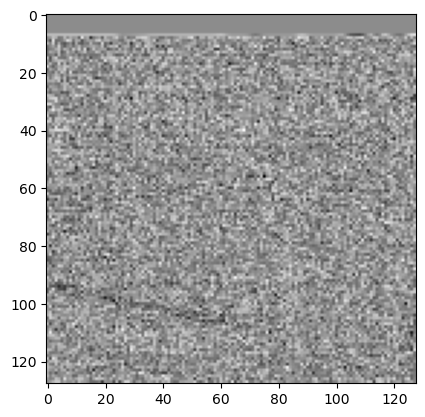

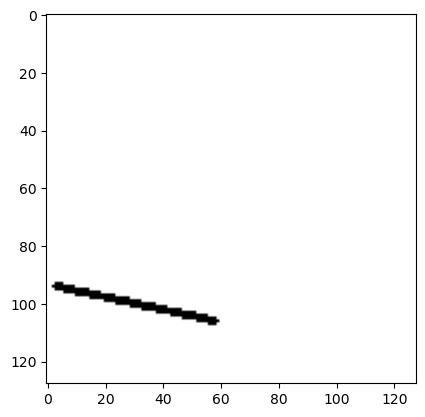

In [39]:
import matplotlib.pyplot as plt
ds = H5Dataset(path)
for x,y in ds:
    if y.sum() > 0:
        break

lol = x[0,:,:]
lol[y[0,:,:] == 1] = x[0,:,:][y[0,:,:] == 1] + 20
plt.imshow(lol, cmap='Grays')
plt.show()
plt.imshow(y[0,:,:], cmap='Grays')
plt.show()

In [36]:
x[0,:,:][y[0,:,:] == 1].mean()

tensor(106.1067)

In [25]:
for imgs, msk in val_loader:
    imgs = imgs.clamp(-10,100)
    print(msk.sum())
    if msk.sum() > 0:
        break

RuntimeError: DataLoader worker (pid(s) 15197, 15198, 15199, 15200, 15201, 15202, 15203, 15204) exited unexpectedly

In [23]:
msk.sum()

tensor(0., device='cuda:0')